In [1]:
# RNN(Long Short-Term Memory, LSTM)

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
%matplotlib inline

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [3]:
def readData():
    train = pd.read_csv("data.csv")
    return train

In [4]:
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [5]:
# Augment Features
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [6]:
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [7]:
from sklearn import preprocessing
def normalize(data):
    minmax_scale=preprocessing.MinMaxScaler(feature_range=(0,1))
    datanormalize=minmax_scale.fit_transform(data)
    return datanormalize

In [8]:
def buildTrain(train, pastDay=1, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=(Y-Z)/2
    Y_train=[]
    for i in range(len(Y)):
        if Y[i]<-5:
            Y_train.append(np.array([0]))
        elif -5<=Y[i]<-4:
            Y_train.append(np.array([1]))
        elif -4<=Y[i]<-3:
            Y_train.append(np.array([2]))
        elif -3<=Y[i]<-2:
            Y_train.append(np.array([3]))
        elif -2<=Y[i]<-1:
            Y_train.append(np.array([4]))
        elif -1<=Y[i]<0:
            Y_train.append(np.array([5]))
        elif 0<=Y[i]<1:
            Y_train.append(np.array([6]))
        elif 1<=Y[i]<2:
            Y_train.append(np.array([7]))
        elif 2<=Y[i]<3:
            Y_train.append(np.array([8]))
        elif 3<=Y[i]<4:
            Y_train.append(np.array([9]))
        elif 4<=Y[i]<5:
            Y_train.append(np.array([10]))
        elif 5<=Y[i]:
            Y_train.append(np.array([11]))
    Y=np.array(Y_train)
    return X, Y

In [9]:
def shuffle1(X,Y):
  np.random.seed()
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [10]:
# 將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [11]:
def buildOneToOneModel(shape):
    model = Sequential()
    model.add(LSTM(36,input_shape=(1, 8),return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(12))
    model.add(Dense(12))
    model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
    model.summary()
    return model

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 36)             6480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 36)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                2352      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
Total params: 8,988
Trainable params: 8,988
Non-trainable params: 0
_________________________________________________________________
Train on 5013 samples, validate on 558 samples
Epoch 1/200
 - 1s - loss: 9.2498 - acc: 0.1193 - val_loss: 7.6080 - val_acc: 0.2473
Epoch 2/200
 - 0s - loss: 8.0888 - acc: 0.2615 - val_loss: 8.1176 - val_acc: 0.2975
Epoch 3/200
 - 0s - loss: 7.9507 - acc: 0.3056 - val_loss

Epoch 87/200
 - 0s - loss: 8.1025 - acc: 0.2075 - val_loss: 8.1746 - val_acc: 0.2401
Epoch 88/200
 - 0s - loss: 8.1379 - acc: 0.2061 - val_loss: 8.5501 - val_acc: 0.2401
Epoch 89/200
 - 0s - loss: 8.3726 - acc: 0.2081 - val_loss: 8.4057 - val_acc: 0.2419
Epoch 90/200
 - 0s - loss: 8.4433 - acc: 0.2109 - val_loss: 8.4634 - val_acc: 0.2419
Epoch 91/200
 - 0s - loss: 8.0800 - acc: 0.2053 - val_loss: 8.4057 - val_acc: 0.2419
Epoch 92/200
 - 0s - loss: 7.9320 - acc: 0.2111 - val_loss: 8.4057 - val_acc: 0.2419
Epoch 93/200
 - 0s - loss: 7.9288 - acc: 0.2107 - val_loss: 8.4057 - val_acc: 0.2419
Epoch 94/200
 - 0s - loss: 7.9288 - acc: 0.2128 - val_loss: 8.4634 - val_acc: 0.2437
Epoch 95/200
 - 0s - loss: 8.0092 - acc: 0.2059 - val_loss: 8.6656 - val_acc: 0.2437
Epoch 96/200
 - 0s - loss: 8.2889 - acc: 0.2089 - val_loss: 8.6656 - val_acc: 0.2437
Epoch 97/200
 - 0s - loss: 8.3148 - acc: 0.2011 - val_loss: 8.9256 - val_acc: 0.2384
Epoch 98/200
 - 0s - loss: 8.1123 - acc: 0.2053 - val_loss: 8.203

Epoch 183/200
 - 0s - loss: 8.3822 - acc: 0.2232 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 184/200
 - 0s - loss: 8.4175 - acc: 0.2296 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 185/200
 - 0s - loss: 8.3822 - acc: 0.2332 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 186/200
 - 0s - loss: 8.3468 - acc: 0.2280 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 187/200
 - 0s - loss: 8.3693 - acc: 0.2352 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 188/200
 - 0s - loss: 8.2793 - acc: 0.2264 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 189/200
 - 0s - loss: 8.2568 - acc: 0.2264 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 190/200
 - 0s - loss: 8.4304 - acc: 0.2306 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 191/200
 - 0s - loss: 8.3500 - acc: 0.2296 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 192/200
 - 0s - loss: 8.3468 - acc: 0.2292 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 193/200
 - 0s - loss: 8.3758 - acc: 0.2296 - val_loss: 8.3768 - val_acc: 0.2849
Epoch 194/200
 - 0s - loss: 8.4497 - acc: 0.2288 - val

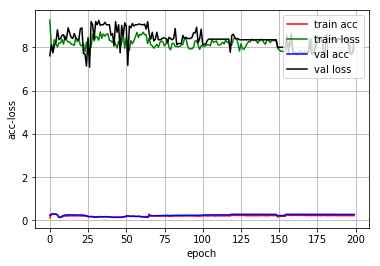

In [13]:
from sklearn.utils import shuffle

mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)

temp=train


train_x1, train_y1 = buildTrain(train, 1, 1)
train_x2, train_y2 = buildTrain(temp, 1, 1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],train_x1.shape[2]))
train_x1=normalize(train_x1)
train_x1= np.reshape(train_x1, (train_x1.shape[0],1,train_x1.shape[1]))
train_x, train_y = train_x1,train_y2
train_x, train_y = shuffle1(train_x, train_y )

train_x, train_y , val_x, val_y = splitData(train_x, train_y , 0.1)

train_y=np_utils.to_categorical(train_y)
val_y=np_utils.to_categorical(val_y)

#train_x= np.reshape(train_x, (train_x.shape[0],train_x.shape[2]))
#val_x= np.reshape(val_x, (val_x.shape[0],val_x.shape[2]))

history = LossHistory()
model = buildOneToOneModel(train_x.shape)



#callback = EarlyStopping(monitor="acc", patience=10, verbose=1, mode="auto")

model.fit(train_x, train_y, epochs=200, batch_size=100,verbose=2, validation_split=0.1,callbacks=[history])

history.loss_plot('epoch')

In [12]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

